In [1]:
import cv2
import matplotlib.pyplot as plt
from cv2.typing import *
import numpy as np
import matplotlib.patches as patches


def load_image(image_path: str):
    image = cv2.imread(image_path)
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def display_image(image: MatLike, title: str):
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')  # Turn off the axis


def quantize_image(image: MatLike, n_colors):
    Z = image.reshape((-1, 3))
    # convert to np.float32
    Z = np.float32(Z)
    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(
        Z, n_colors, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    final_image = res.reshape((image.shape))

    return final_image

In [2]:
colors = 13*12
quantized_image = quantize_image(
    load_image(image_path="images/Ittens Colors.png"), colors)

In [3]:
def get_colors(image_array):
    colors = {}
    i = 0
    j = 0
    while i < image_array.shape[0]:
        while j < image_array.shape[1]:
            pixel = tuple(image_array[i, j])
            if pixel in colors:
                colors[pixel] = colors[pixel]+1
            else:
                colors[pixel] = 1
            j = j+1
        j = 0
        i = i+1
    return colors

In [4]:
def build_ittens_colors(image: MatLike):
    ittens_colors = {}
    i = 1
    j = 1
    cut = (int(image.shape[1]/12),  int(image.shape[0]/12))
    start_point = [0, cut[0]]
    while i < 13:
        ittens_colors[i] = []
        while j < 13:
            y = start_point[0]
            x = start_point[1]
            cropped_image = image[y:y+cut[0], x:x+cut[1]]
            colors = get_colors(quantize_image(cropped_image, 1)).keys()
            first_color = next(iter(colors), None)
            if first_color is not None:
                ittens_colors[i].append(first_color)
            start_point[0] = start_point[0] + cut[0]
            j += 1
        j = 1
        start_point[0] = 0
        start_point[1] = start_point[1] + cut[1]
        i += 1
    return ittens_colors

In [5]:
ittens_image = load_image("images/Ittens Colors.png")
ittens_colors = build_ittens_colors(ittens_image)
print(len(ittens_colors))

12


In [6]:
def get_color_value(ittens_colors: dict):
    for color in ittens_colors.keys():
        colors = ittens_colors.get(color)
        fig, ax = plt.subplots(1, 1, figsize=(10, 2))

        # Para cada color en la lista de colores
        for i, color in enumerate(colors):
            # Convertir el color de formato string a formato RGB
            rgb = color
            rgb = [c/255. for c in rgb]  # Normalizar a [0, 1]

            # Dibujar un rectángulo en el eje con el color correspondiente
            rect = patches.Rectangle((i, 0), 1, 1, facecolor=rgb)
            ax.add_patch(rect)

        # Configurar el eje
        ax.set_xlim(0, len(colors))
        ax.set_ylim(0, 1)
        ax.axis('off')  # Ocultar los ejes

        plt.show()

In [7]:
def show_color_palette(colors):
    c = np.array(colors)/255
    fig,ax = plt.subplots()
    for i,color in enumerate(c):
        rect = patches.Rectangle((i,0),1,0.2,facecolor=color)
        ax.add_patch(rect)
    ax.set_xlim(0,len(colors))
    ax.set_ylim(0,0.2)
    ax.axis("off")

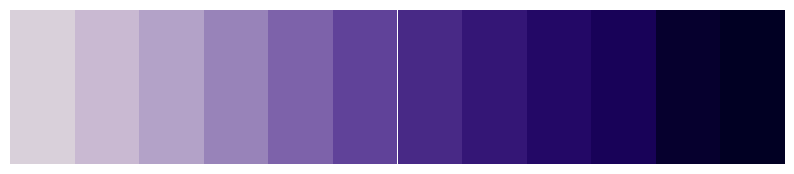

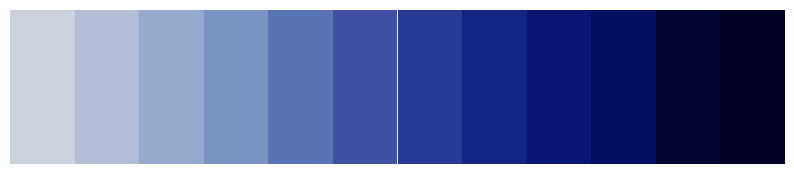

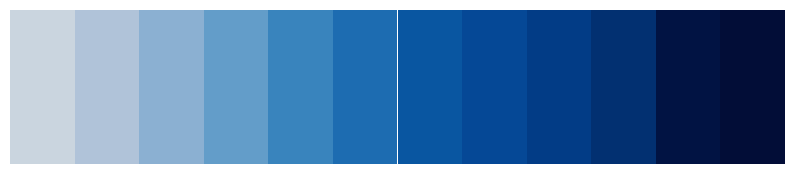

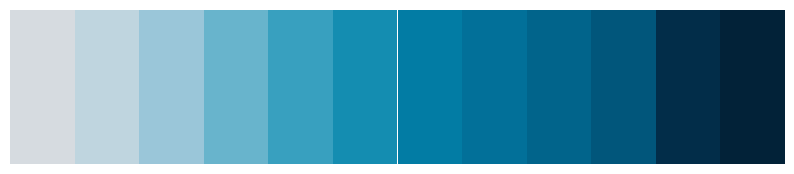

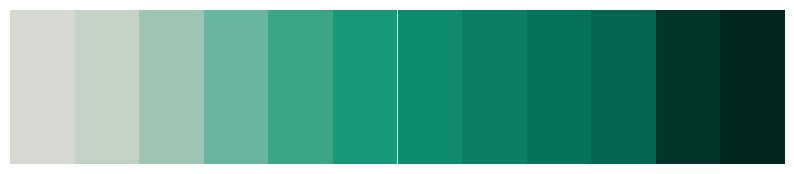

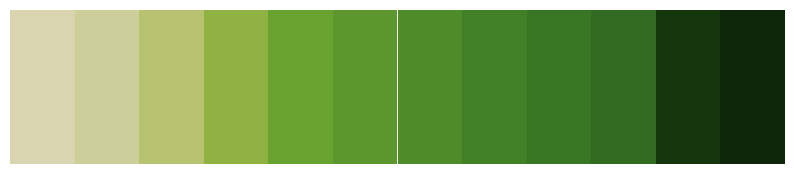

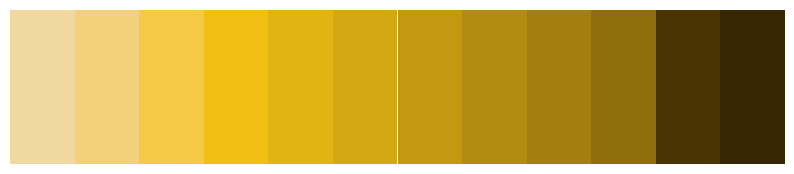

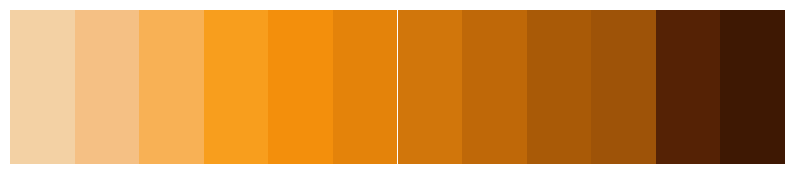

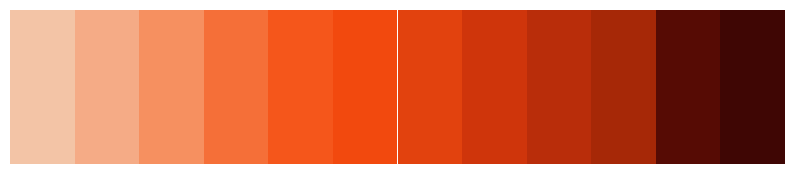

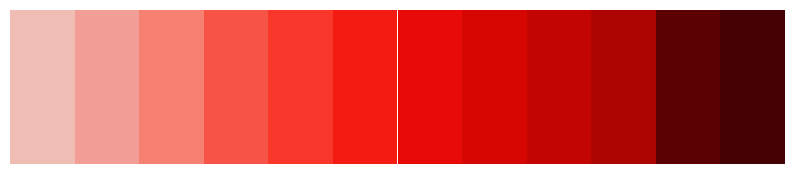

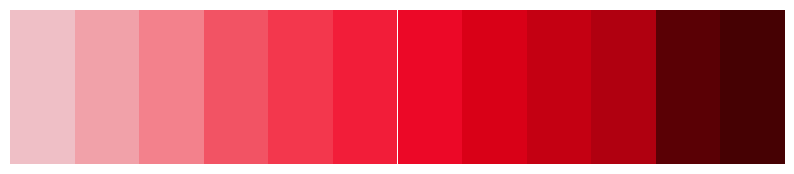

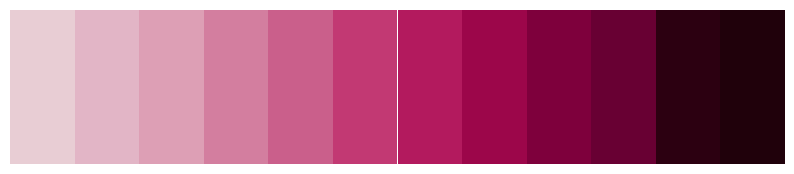

In [8]:
get_color_value(ittens_colors)

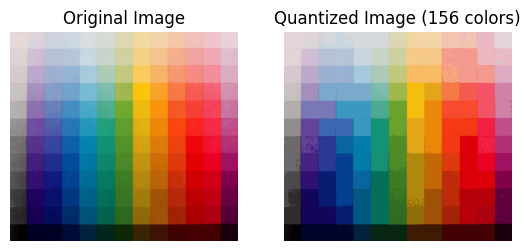

In [11]:
plt.figure(figsize=(10, 3))
plt.subplot(131)
display_image(load_image(image_path="images/Ittens Colors.png"),
              'Original Image')


plt.subplot(132)
display_image(quantized_image, f'Quantized Image ({colors} colors)')

In [39]:
def color_distance(c1,c2):
    d = np.subtract(c1,c2)
    d = np.linalg.norm(d,axis=2)
    return d
def matrix_min_indexes(matrix):
    min_index = np.argmin(matrix)
    (i1,i2) = np.unravel_index(min_index,matrix.shape)
    return (i1+1,i2)
def angle_to_index(angle,list_length):
    return round(angle/360*list_length)
def rgb_to_hsv(rgb):
    to_convert = np.array([[rgb]],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0][0]
def rgbs_to_hsv(rgbs):
    to_convert = np.array([rgbs],dtype=np.uint8)
    return cv2.cvtColor(to_convert,cv2.COLOR_RGB2HSV)[0]
def group_hues(colors, n):
    """
    Given some colors and N hues to separate into, returns a dictionary that maps each color
    to its group index
    --- 
    Inputs
        colors: A list of tuples, each containing a color in RGB values.
        n: The number of hue groups to separate into
    Returns
        index_groups: A list of the hue groups, with the colors represented as indexes of the original list
        color_groups: A list of the hue groups, with the colors represented with their RGB value
        group_hues: A list that contains the hues of each group
    """
    
    hues = [rgb_to_hsv(c)[0] for c in colors]
    hues = np.float32(hues)
    
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _,labels,centers = cv2.kmeans(hues, n, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    group_hues = centers
    labels = labels.flatten()
    
    groups = [hues[labels==i] for i in range(n)]
    index_groups = [np.arange(len(colors))[labels == i].tolist() for i in range(n)]
    color_groups = [np.array(colors)[labels==i].tolist() for i in range(n)]
    color_groups = [[tuple(c) for c in g] for g in color_groups]

    hue_mappings = {h:i for i,g in enumerate(groups) for h in g}
    color_mappings = {tuple(colors[i]):hue_mappings[hues[i]] for i in range(len(colors))}
    return index_groups, color_groups, group_hues
def group_hues_threshold(colors,hue_threshold):
    hues = [rgb_to_hsv(c)[0] for c in colors]
    
def find_closest_color(color,color_scheme:dict):
    """
    Given a color and a scheme, returns the index corresponding to the closest match in the color scheme
    ---
    Inputs
        color: The tuple of the RGB color to find the match for
        color_scheme: Dictionary with RGB values grouped by hues
    Returns
        index: A tuple with the 2 values needed to index the scheme for the matching color
    """
    matrix = [color_scheme[key] for key in sorted(color_scheme)]
    matrix = np.array(matrix)
    min_indices = [matrix_min_indexes(color_distance(c,matrix)) for c in color]
    return min_indices
def convert_im_to_scheme(quantized_image,color_scheme):
    colors = get_colors(quantized_image)
    color_palette = list(colors.keys())
    indexes = find_closest_color(color_palette,ittens_colors)
    new_im = quantized_image.copy()

    for i,og in enumerate(color_palette):
        mask = cv2.inRange(quantized_image,np.array(og),np.array(og))
        ind = indexes[i]
        new_im[mask > 0] = color_scheme[ind[0]][ind[1]]
    return new_im
def convert_im_palette(quantized_image,color_palette):
    colors = get_colors(quantized_image)
    og_palette = list(colors.keys())
    new_im = quantized_image.copy()
    for i,og in enumerate(og_palette):
        mask = cv2.inRange(quantized_image,np.array(og),np.array(og))
        new_im[mask > 0] = color_palette[i]
    return new_im

# Aplicación a un diseño de personaje

## Diseño original

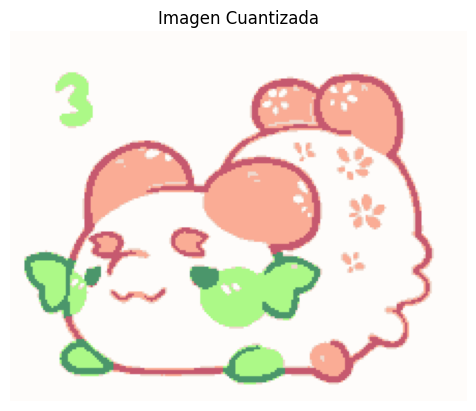

In [100]:
image = load_image("images/Slug.png")
q_im = quantize_image(image,6)
display_image(q_im,"Imagen Cuantizada")

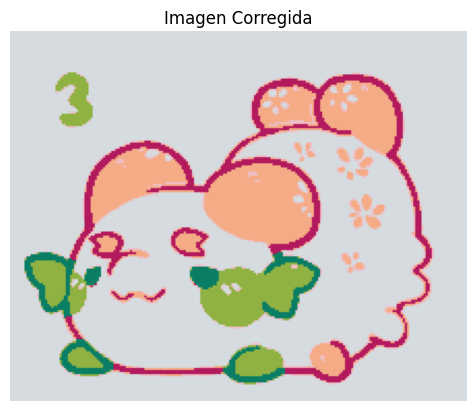

In [101]:
colors = get_colors(q_im)
color_palette = list(colors.keys())
indexes = find_closest_color(color_palette,ittens_colors)
new_colors = [ittens_colors[i][j] for i,j in indexes]

corrected = convert_im_palette(q_im,new_colors)
display_image(corrected,"Imagen Corregida")

## Retoque de paleta de colores

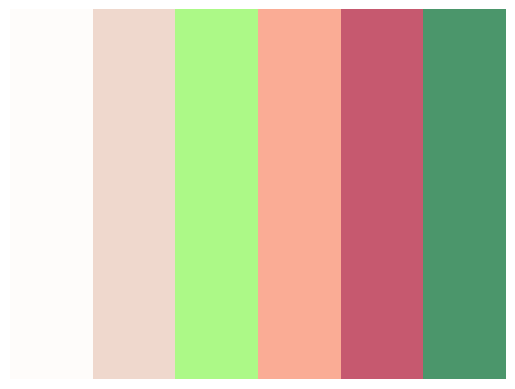

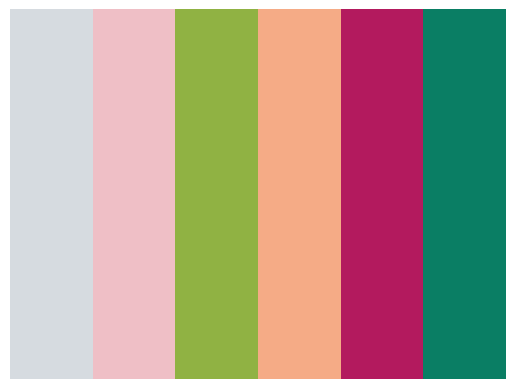

In [102]:
show_color_palette(color_palette)
show_color_palette(new_colors)

In [103]:
i_groups,groups,hues = group_hues(color_palette,3)
# Grab the cuantities of each hue group
hue_quantities = [sum([colors[c] for c in g]) for g in groups]
lightnesses = [i[1] for i in indexes]

print("Hues:",hues)
print("Groups:",groups)
print("Groups w/ indexes",i_groups)
print("Quantities:",hue_quantities)
print("Lightness indexes of the palette:",lightnesses)
print("Indexes od the palette",indexes)

# Idea:
# Get color indexes from ittens
# indexes

# Group by ittens' hues
# Get dominant hue
# Get complementary hue
# Switch non dominant colors to the complementary hue

Hues: [[ 10.666667]
 [ 61.5     ]
 [174.      ]]
Groups: [[(254, 252, 250), (239, 216, 205), (250, 172, 149)], [(172, 249, 135), (75, 150, 107)], [(198, 89, 111)]]
Groups w/ indexes [[0, 1, 3], [2, 5], [4]]
Quantities: [34218, 3109, 2232]
Lightness indexes of the palette: [0, 0, 3, 1, 6, 7]
Indexes od the palette [(4, 0), (11, 0), (6, 3), (9, 1), (12, 6), (5, 7)]


0 10.666667
[0, 1, 3]
8.0
2.0
[2 5 4]
[[ 4  0]
 [11  0]
 [ 6  3]
 [ 9  1]
 [12  6]
 [ 5  7]]
[[ 4  0]
 [11  0]
 [ 2  3]
 [ 9  1]
 [ 2  6]
 [ 2  7]]
[(214, 219, 224), (239, 191, 198), (122, 147, 194), (245, 171, 134), (39, 57, 149), (20, 36, 133)]


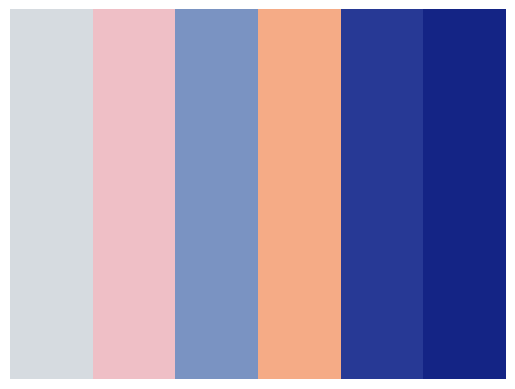

In [104]:
# 1. Traducir color dominante directamente a ittens
max_hue_group_i = max(enumerate(hue_quantities),key=lambda t: t[1])[0]
max_hue_group = i_groups[max_hue_group_i]
max_hue = hues[max_hue_group_i][0]

print(max_hue_group_i, max_hue)
print(max_hue_group)

avg_palette_hue = np.floor(sum(indexes[i][0] for i in max_hue_group)/len(max_hue_group))
print(avg_palette_hue)
#mappings = {c:find_closest_color([c],ittens_colors) for c in groups[max_hue_group]}
#print(mappings)
# Obtener complementario
complementary_i = (avg_palette_hue + angle_to_index(180,len(ittens_colors))) % len(ittens_colors)
print(complementary_i)

to_modify = np.array(i_groups,dtype=object)[np.arange(len(i_groups))!=0]
to_modify = np.array([i for l in to_modify for i in l])
new_indexes = np.array(indexes)
print(to_modify)
print(new_indexes)
new_indexes[to_modify,0] = complementary_i
print(new_indexes)
new_palette = [ittens_colors[i][j] for i,j in new_indexes]
print(new_palette)
show_color_palette(new_palette)

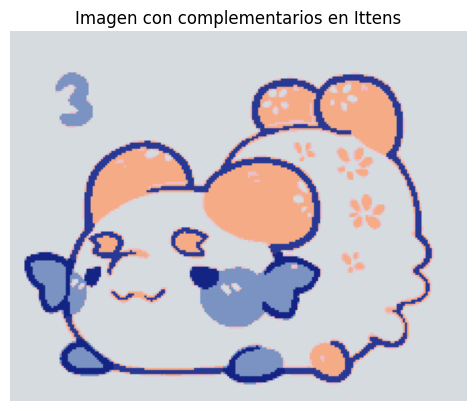

In [105]:
complemented = convert_im_palette(q_im,new_palette)
display_image(complemented, "Imagen con complementarios en Ittens")

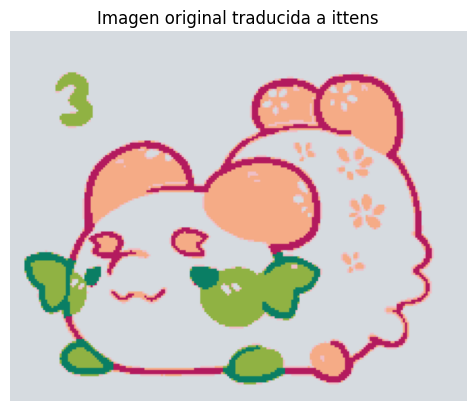

In [106]:
display_image(corrected, "Imagen original traducida a ittens") 